In [ ]:
##MODIFIED FUNC for HEV

In [26]:
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import networkx as nx

def measure_TLS_HEV(df, radius):
    """
    Classify clusters of cells into TLS categories.

    :param df: DataFrame with columns ['X', 'Y', 'Phenotype']
    :param radius: Radius to consider for neighborhood
    :return: DataFrame with TLS classification
    """
    # Create KDTree for spatial querying
    tree = KDTree(df[['X', 'Y']].values)

    # Initialize an empty list to store TLS classification results
    tls_classifications = []

    # Analyze each node
    for idx, row in df.iterrows():
        # Find all neighboring cells within the specified radius
        neighbors = tree.query_ball_point([row['X'], row['Y']], r=radius)
        neighbor_phenotypes = df.iloc[neighbors]['Phenotype']

        # Count the number of T cells and B cells in the neighborhood
        bt_cell_count = sum(neighbor_phenotypes.isin(['B-cell', 'T-cell']))

        # Check for presence of HEV in the neighborhood
        contains_HEV = any(neighbor_phenotypes.isin(['HEV']))

        # Classification logic based on the count of B and T cells and the presence of HEV
        if bt_cell_count >= 50 and contains_HEV:
            tls_classifications.append('Primary Follicle-like TLS')
        elif bt_cell_count >= 50:
            tls_classifications.append('Lymphoid Aggregate')
        else:
            tls_classifications.append('Not TLS')

    # Add classification results to DataFrame
    df['TLS_Classification'] = tls_classifications

    # Return the results
    return df

# # Example usage with random data:
# df = pd.DataFrame({
#     'X': np.random.rand(100),
#     'Y': np.random.rand(100),
#     'Phenotype': np.random.choice(['B-cell', 'T-cell', 'HEV', 'fDC'], 100)


# Example for Mature TLS with HEV at center

In [ ]:
## Synthetic Data for TLS with HEV

In [44]:
import pandas as pd
import numpy as np

# Set the random seed for reproducibility
np.random.seed(0)

# Number of cells
n_cells = 120000

# HEV center coordinates
hev_center_x = 5000  # Center of the circular formation
hev_center_y = 5000

# Number of cells in circular layers (HEV, B cells, and T cells)
hev_cells = 1  # Single HEV in the center
b_cells = 3000  # Number of B cells around the HEV
t_cells = 2000  # Number of T cells in the outermost layer

# Radius ranges for the circular layers (in microns)
radius_hev = 0  # HEV at the center
radius_b_cells_min, radius_b_cells_max = 100, 400  # B cell layer
radius_t_cells_min, radius_t_cells_max = 400, 600  # T cell layer

# Function to generate random points in a circular formation
def generate_circle_coordinates(center_x, center_y, radius_min, radius_max, num_cells):
    radii = np.random.uniform(radius_min, radius_max, num_cells)
    angles = np.random.uniform(0, 2 * np.pi, num_cells)
    x_coords = center_x + radii * np.cos(angles)
    y_coords = center_y + radii * np.sin(angles)
    return x_coords, y_coords

# Generate HEV coordinates (single point at the center)
hev_x = np.array([hev_center_x])
hev_y = np.array([hev_center_y])
hev_phenotype = ['HEV']

# Generate B cell coordinates in the next layer around the HEV
b_x, b_y = generate_circle_coordinates(hev_center_x, hev_center_y, radius_b_cells_min, radius_b_cells_max, b_cells)
b_phenotype = ['B-cell'] * b_cells

# Generate T cell coordinates in the outer layer around the B cells
t_x, t_y = generate_circle_coordinates(hev_center_x, hev_center_y, radius_t_cells_min, radius_t_cells_max, t_cells)
t_phenotype = ['T-cell'] * t_cells

# Randomly distribute the remaining cells outside the circular formation
remaining_cells = n_cells - (hev_cells + b_cells + t_cells)
random_x = np.random.uniform(0, 10000, remaining_cells)
random_y = np.random.uniform(0, 10000, remaining_cells)
random_phenotypes = np.random.choice(['Others', 'B-cell', 'T-cell'], remaining_cells)  # Randomly assign phenotypes

# Combine all coordinates and phenotypes
x_coordinates = np.concatenate([hev_x, b_x, t_x, random_x])
y_coordinates = np.concatenate([hev_y, b_y, t_y, random_y])
phenotypes = np.concatenate([hev_phenotype, b_phenotype, t_phenotype, random_phenotypes])

# Create DataFrame
df = pd.DataFrame({
    'X': x_coordinates,
    'Y': y_coordinates,
    'Phenotype': phenotypes
})

df.head()


,X,Y,Phenotype
0,5000.000000,5000.000000,HEV
1,4773.092760,5136.196836,B-cell
2,4784.121737,4771.215031,B-cell
3,5050.166241,4723.688070,B-cell
4,5156.939633,4788.378324,B-cell


In [45]:
df.Phenotype.value_counts()

Phenotype
B-cell    41328
T-cell    40120
Others    38551
HEV           1
Name: count, dtype: int64

In [71]:
##PLOT

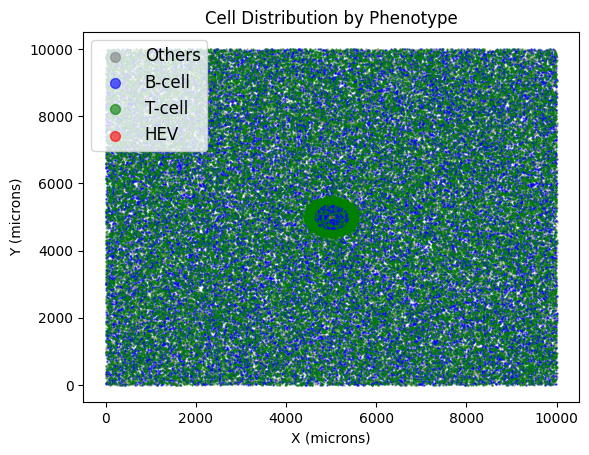

In [73]:
import matplotlib.pyplot as plt

# Set up the color mapping for each phenotype, including 'Others'
color_mapping = {
    'Others': 'gray',
    'B-cell': 'blue', 
    'T-cell': 'green', 
    'HEV': 'red',
}

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each cell, coloring by phenotype
for phenotype, color in color_mapping.items():
    # Select the rows corresponding to the current phenotype
    phenotype_data = df[df['Phenotype'] == phenotype]

    # Plot these cells with the specified color and small dot size
    ax.scatter(phenotype_data['X'], phenotype_data['Y'], color=color, label=phenotype, s=0.5, alpha=0.6)

# Add labels and legend with larger markers and adjusted font size
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_title('Cell Distribution by Phenotype')

# Modify the legend marker size and font size
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.legend(markerscale=10, fontsize=12)

# Show the plot
plt.show()


In [ ]:
##MEASURE TLS

In [38]:
tls_result = measure_TLS_HEV(df, radius=80)

In [39]:
tls_result['TLS_Classification'].value_counts()

TLS_Classification
Not TLS                      113900
Lymphoid Aggregate             6083
Primary Follicle-like TLS        17
Name: count, dtype: int64

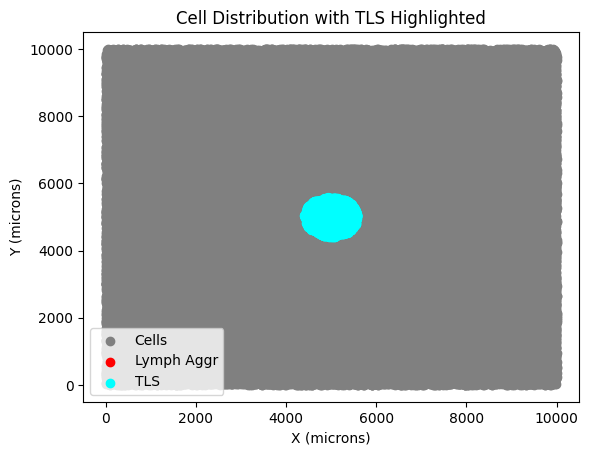

In [59]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot all cells
ax.scatter(df['X'], df['Y'], color='gray', label='Cells')

# Highlight Early TLS cells
early_tls_cells = tls_result[tls_result['TLS_Classification'] == 'Lymphoid Aggregate']
ax.scatter(early_tls_cells['X'], early_tls_cells['Y'], color='red', label='Lymph Aggr')

mature_tls_cells = tls_result[tls_result['TLS_Classification'] == 'Primary Follicle-like TLS ']
ax.scatter(early_tls_cells['X'], early_tls_cells['Y'], color='cyan', label='TLS')

# Add labels and legend
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_title('Cell Distribution with TLS Highlighted')
ax.legend()

# Show the plot
plt.show()


In [ ]:
## FOR JUST THE AGGREGATES

In [67]:
tls_result2 = measure_TLS(df, radius=120)

In [68]:
tls_result2 

,X,Y,Phenotype,TLS_Classification
0,5000.000000,5000.000000,HEV,Lymphoid Aggregate
1,4773.092760,5136.196836,B-cell,Lymphoid Aggregate
2,4784.121737,4771.215031,B-cell,Lymphoid Aggregate
3,5050.166241,4723.688070,B-cell,Lymphoid Aggregate
4,5156.939633,4788.378324,B-cell,Lymphoid Aggregate
...,...,...,...,...
119995,6741.343401,7095.080421,B-cell,Not TLS
119996,8336.967779,9969.963492,B-cell,Not TLS
119997,2352.319836,1456.983665,B-cell,Not TLS
119998,9439.865846,9821.950943,T-cell,Not TLS


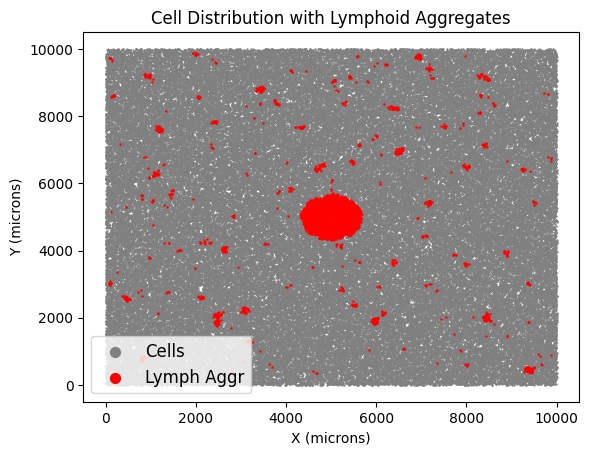

In [74]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot all cells
ax.scatter(df['X'], df['Y'], color='gray', label='Cells', s=0.5)

# Highlight Early TLS cells
early_tls_cells = tls_result2 [tls_result2 ['TLS_Classification'] == 'Lymphoid Aggregate']
ax.scatter(early_tls_cells['X'], early_tls_cells['Y'], color='red', label='Lymph Aggr', s=0.5)

# mature_tls_cells = df[df['TLS_Classification'] == 'Primary Follicle-like TLS ']
# ax.scatter(early_tls_cells['X'], early_tls_cells['Y'], color='cyan', label='TLS')

# Add labels and legend
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_title('Cell Distribution with Lymphoid Aggregates')
ax.legend(markerscale=10, fontsize=12)
# ax.legend()

# Show the plot
plt.show()